<a href="https://colab.research.google.com/github/nenecchiCV/internal-competition-2024/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAICC forum 2024 社内MLコンペティションvol.3　チュートリアル

---

### ライブラリのインポート

本notebookで用いるライブラリ群をあらかじめインポートしておきます。

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

### パスの設定

本noteboookをご自身の環境で実行される際、環境に合わせて変更してください。

In [7]:
INPUT_DIR = "/content/drive/MyDrive/daicc2024/"
OUTPUT_DIR = "/content/drive/MyDrive/daicc2024/tutorial/"

---

## 1. データの探索・理解 (EDA: Exploratory Data Analysis)

今回扱うデータは、ある製品の製造時の中間測定結果および最終測定結果の実績が記録されたデータです。  
別資料で既に説明した通り、最終工程の設定値を上手く操作することで製造品質の向上に取り組まれており、

 - data_1.csv: 固定値運用時の実績データ
 - data_2.csv: 現行モデル運用時の実績データ

の2種類の過去データが与えられています。  
まずは、前者のデータから中身を確認しましょう。

In [8]:
df_1 = pd.read_csv(INPUT_DIR + "data_1.csv")
df_1

,id,obs_11,obs_12,obs_13,obs_14,obs_15,obs_21,obs_22,obs_23,obs_24,obs_25,obs_31,obs_32,obs_33,obs_34,obs_35,parameter,spec
0,0,62.01457,91.65045,48.20859,73.31024,76.13590,60.20358,96.17887,87.30840,84.63313,40.50873,70.01471,14.47043,42.81627,50.29044,113.68448,0.0,98.64420
1,1,60.69702,90.91513,48.58664,73.18577,76.88932,61.62932,98.17003,88.02719,83.83372,43.05050,53.33085,24.38429,104.27514,36.71392,104.62515,0.0,100.92119
2,2,60.47336,90.45913,48.65129,73.11828,76.60147,61.97207,97.29511,85.52639,86.61886,40.13236,76.22214,13.96032,29.86299,60.08177,119.78403,0.0,97.04798
3,3,60.56826,90.90713,48.94006,73.18156,77.07093,60.86407,96.14732,87.48353,84.64801,40.40228,73.93093,18.26402,60.49384,52.88122,114.96104,0.0,96.81147
4,4,60.63285,90.73787,48.52429,73.19398,76.66164,59.77490,96.68002,87.39572,86.15437,40.13888,63.38943,29.94443,78.32125,46.80220,103.40444,0.0,100.10177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,60.53828,90.72711,48.37947,73.17227,76.49698,60.77852,97.37184,86.53095,91.05897,38.69401,69.88900,18.57505,55.36895,59.31049,117.23303,0.0,99.23446
9996,9996,60.81165,90.99689,48.17869,73.38743,76.49717,60.38357,96.97468,86.74819,85.76441,40.33806,62.39703,28.05657,80.46318,45.89883,104.35105,0.0,100.60543
9997,9997,60.62243,90.95900,48.64086,73.11600,76.59780,61.08308,97.97874,86.95818,87.16167,39.94593,70.26639,16.05685,67.50411,56.74852,118.85758,0.0,99.58981
9998,9998,60.46640,90.87006,48.66590,73.16539,76.93844,60.78271,98.39057,91.18609,84.13603,41.13007,64.57006,19.18986,80.94210,44.92665,110.29426,0.0,100.54856


10,000行のデータが格納されています。

今回のタスクの目的は、spec値を可能な限り100に近付けるようなparameterの値を推測することですが、  
data_1.csvは固定値運用時の実績データなので、parameter列には固定値(0)しか入っていません。

In [9]:
df_1["parameter"].value_counts()

0.0    10000
Name: parameter, dtype: int64

まずは、ターゲットであるspec値の分布を確認しておきましょう。

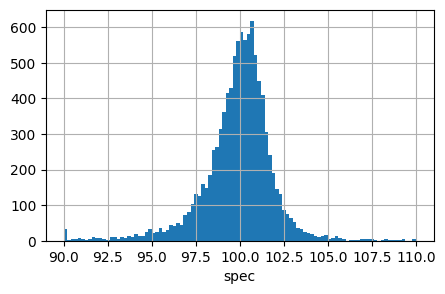

In [10]:
plt.figure(figsize=(5, 3))
plt.hist(df_1["spec"], bins=100)
plt.xlabel("spec")
plt.grid()
plt.show()

90～110の範囲にクリッピングされているようですが、概ね100を中心とした分布になっています。  
平均的にはspec値が100となるように製造できていますが、このばらつきをより抑えたい、というのが製造側の要望です。  
今回の評価指標である、100からの偏差の絶対平均を算出してみましょう。

In [11]:
np.abs(100 - df_1["spec"]).mean().round(3)

1.387

固定値運用時の平均は、約1.387という値になりました。  
sample_submission_1.csvには、parameter列に全て0が入っているので、これをそのまま提出すると、同程度のスコアになることが予想されます。  
実際に提出すると **Public Score = 1.395** という結果を得ます。

spec値と各中間観測値の関連を、散布図で確認してみましょう。

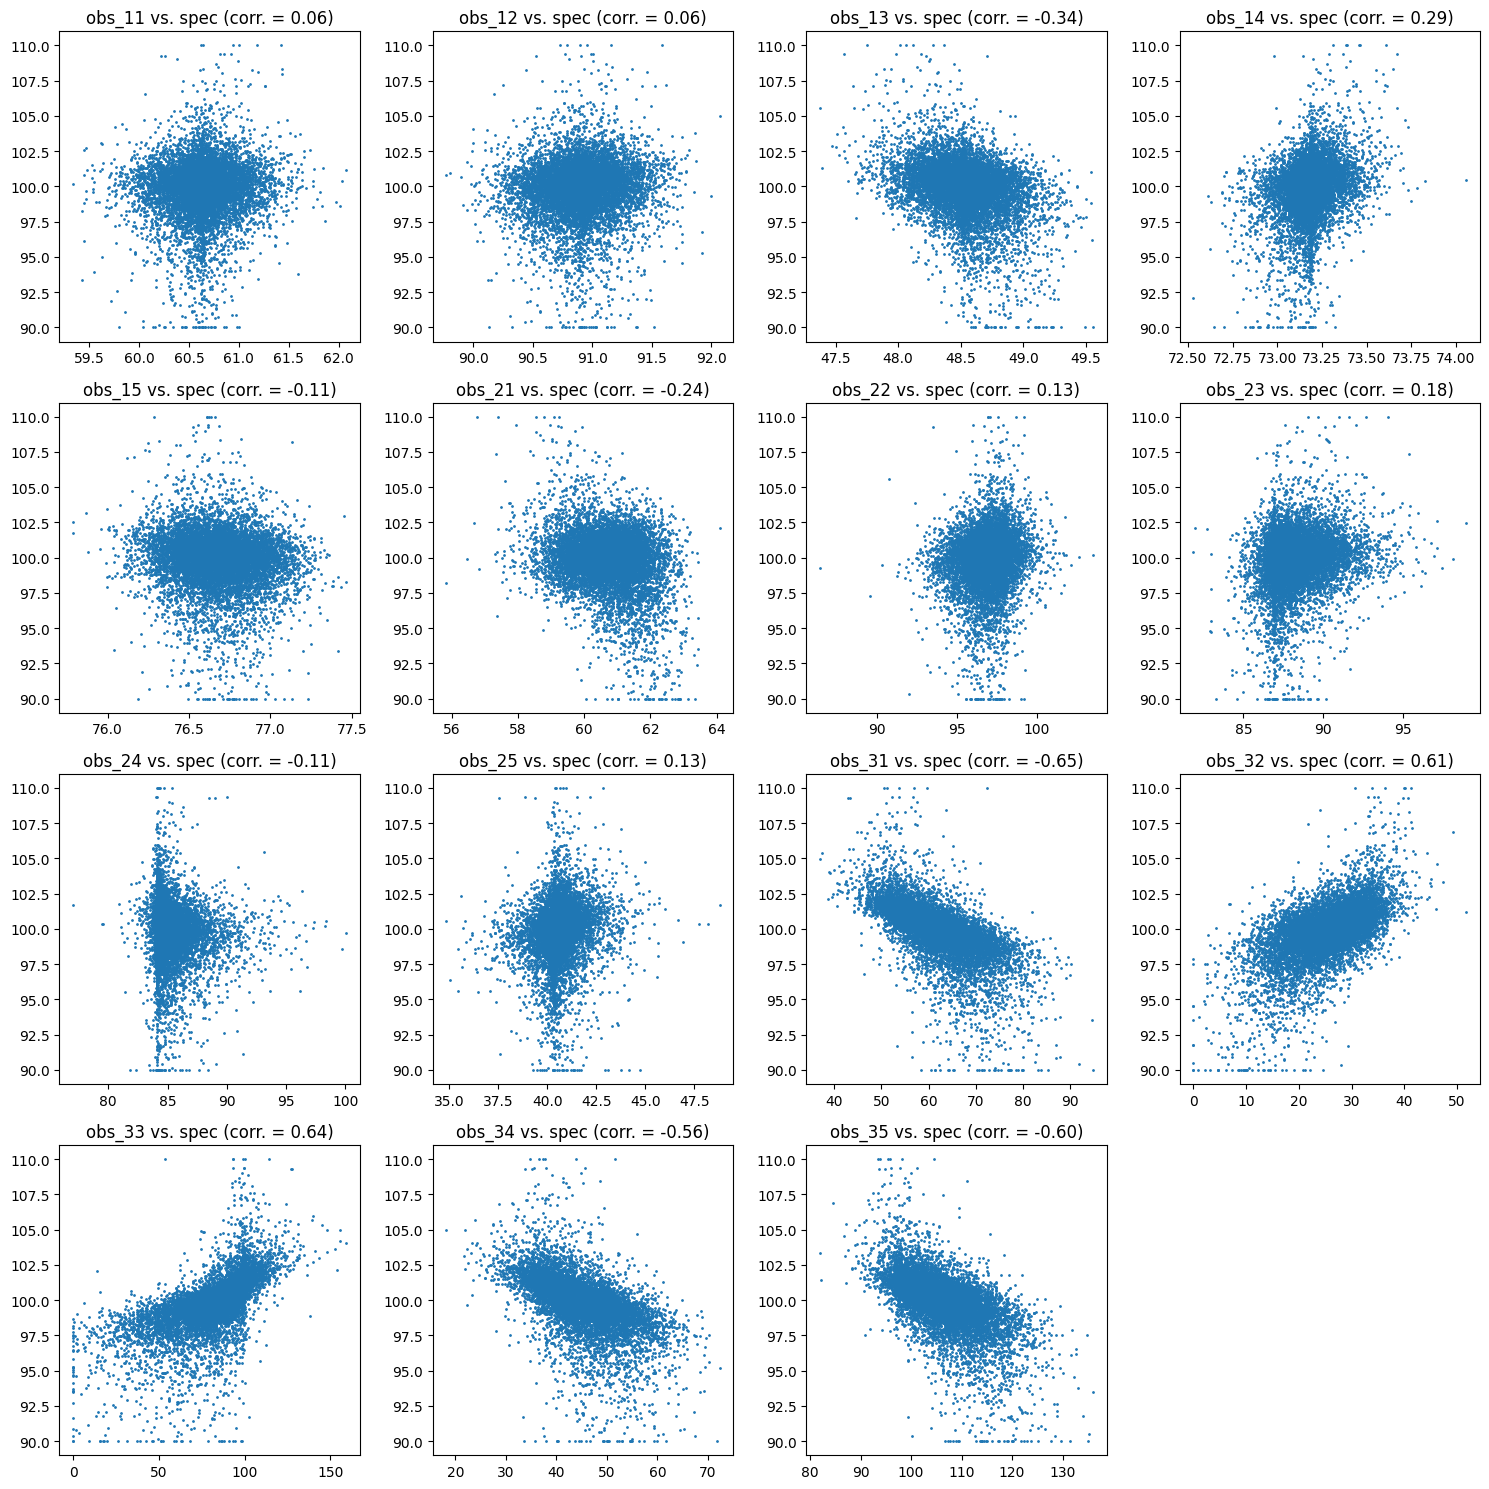

In [12]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=4, ncols=4)
for i, col in enumerate(df_1.columns[1:-2]):
    corr = df_1[col].corr(df_1["spec"])
    ax = axes[i//4, i%4]
    ax.scatter(df_1[col], df_1["spec"], s=1)
    ax.set_title(f"{col} vs. spec (corr. = {corr:.2f})")
fig.delaxes(axes[-1, -1])
fig.tight_layout()
plt.show()

グラフタイトルに相関係数を付記しています。  
基本的には、spec値はより後半の工程で得られた中間観測値との相関が強そうですが、前半工程の中間観測値とも関連がありそうです。  
（後半の工程は前半の工程の影響を受けた結果なので、当然とは言えますが。）

次に、もう一つのデータについても同様に確認をしてみましょう。

In [13]:
df_2 = pd.read_csv(INPUT_DIR + "data_2.csv")
df_2

,id,obs_11,obs_12,obs_13,obs_14,obs_15,obs_21,obs_22,obs_23,obs_24,obs_25,obs_31,obs_32,obs_33,obs_34,obs_35,parameter,spec
0,10000,60.38193,90.70221,48.52633,73.16941,76.65915,60.67883,97.11232,88.47652,85.12416,40.30306,54.86488,32.97126,102.44558,38.56385,99.83647,-1.5,100.11816
1,10001,61.05361,91.09555,48.24572,73.22079,76.28240,61.05229,98.38354,85.53275,84.78158,41.11908,66.07561,27.10735,60.26512,48.45918,104.96563,-0.5,99.20744
2,10002,61.01046,91.44952,48.55820,73.18440,76.53864,59.64101,97.18673,88.77663,84.85618,40.41312,63.92861,28.05371,74.94273,45.60964,103.85381,-1.0,98.61717
3,10003,60.82294,90.96308,48.44852,73.23090,76.53440,59.77653,97.29187,90.38223,84.16805,40.98538,63.03114,29.18294,73.23717,44.75108,102.31228,0.5,100.87970
4,10004,60.71127,90.86153,48.04042,73.25019,76.61452,61.10784,94.94269,87.58174,84.64093,40.33127,63.30563,16.63220,87.84101,44.64803,112.57412,0.0,100.01477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995,60.67936,90.91449,48.30130,73.18465,76.60112,62.67463,95.76115,86.73186,84.28776,40.57691,53.61413,20.92958,98.83928,38.98419,107.02439,-0.5,100.20070
9996,19996,60.72153,91.33213,48.51158,73.16385,76.42545,60.18276,95.00719,87.85947,87.31522,39.17187,63.35262,23.71712,89.21206,47.18434,109.43167,-2.0,98.46463
9997,19997,60.83138,90.88876,48.43254,73.24799,76.70641,59.85654,97.47942,87.75259,85.78767,40.28782,64.08205,25.30145,74.19079,47.84901,106.91453,0.0,99.70675
9998,19998,60.63080,90.87945,48.51816,73.10603,76.65103,60.97056,96.61125,87.80183,85.44466,40.16829,58.63908,27.58175,93.09631,43.38907,104.42003,-0.5,97.65309


こちらのデータには、parameter列に有効な値が入っています。  
これは、現行方式で算出された値であり、この算出ロジックの改善が今回の取り組みの目的です。

現行のparameterの設定パターンをヒストグラムで確認しましょう。

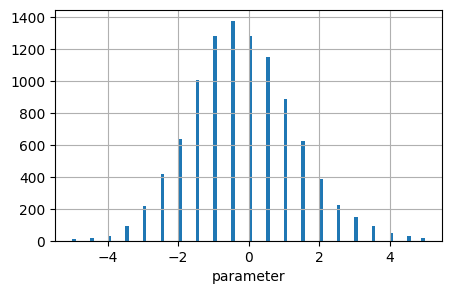

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(df_2["parameter"], bins=100)
plt.xlabel("parameter")
plt.grid()
plt.show()

離散的な値を取っており、また現行の運用では、parameterの値は-5～+5の範囲に制限されているようです。  
（別資料に記載の通り、parameterの値は-10～+10まで設定可能です。）

蛇足ですが、離散的な値を取るデータのヒストグラムを粗い粒度で描くと、ミスリーディングな可視化になることがあります。

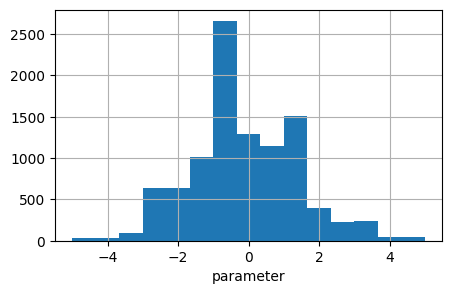

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(df_2["parameter"], bins=15)
plt.xlabel("parameter")
plt.grid()
plt.show()

最も強いピークの高さが先ほどよりも極端になっており、また+1付近にも不自然なピークがあります。  
これは、ヒストグラムの一つの棒（ビンと言います）に入る値の種類が、そこだけ多くなっているためです。  
離散的な値を取るデータのヒストグラムは、一つのビンに1種類の値しか入らないよう、多めのビン数で描画する方がよいでしょう。

少し脱線しましたが、次に両データにおけるspec値の分布の違いをヒストグラムで可視化してみましょう。

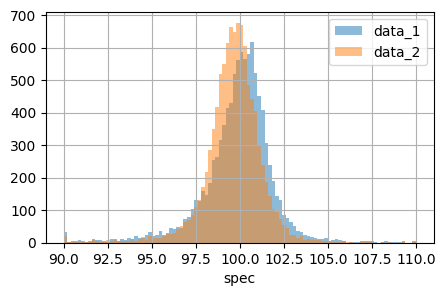

In [16]:
plt.figure(figsize=(5, 3))
plt.hist(df_1["spec"], bins=100, alpha=0.5, label="data_1")
plt.hist(df_2["spec"], bins=100, alpha=0.5, label="data_2")
plt.xlabel("spec")
plt.legend()
plt.grid()
plt.show()

少々わかりにくいですが、data_2の方がより中心にデータが集まっていそうです。  
data_2おける平均絶対偏差を計算してみましょう。

In [17]:
np.abs(100 - df_2["spec"]).mean().round(3)

1.157

平均絶対偏差は約1.157となっており、確かに固定値運用よりも優秀であることがわかります。  

sample_submission_2.csvには、parameter列に現行モデルで算出した値が入っているので、これを提出すると、上記と同程度のスコアになることが予想されます。  
実際に提出すると **Public Score = 1.173** という結果を得ます。

parameterの調整によってspec値をコントロールできるのだから、両者には当然深い関係がありそうです。  
しかし、このデータで両者の散布図を描いてみると、少し意外な結果になります。

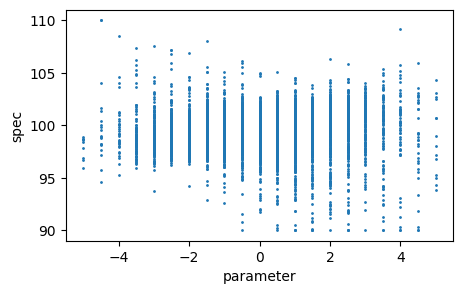

In [18]:
plt.figure(figsize=(5, 3))
plt.scatter(df_2["parameter"], df_2["spec"], s=1)
plt.xlabel("parameter")
plt.ylabel("spec")
plt.show()

まず、paramterが離散値を取っているので、単なる散布図では傾向を掴みづらいです。  
このような場合は、小さい乱数ノイズを加えて可視化するとよいです。  
（このような可視化をjitter plotと言いますが、matplotlibにはそのような関数が用意されていないので、明示的に正規乱数ノイズを加えます。）

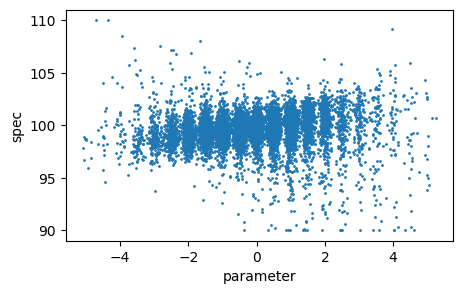

In [19]:
plt.figure(figsize=(5, 3))
plt.scatter(df_2["parameter"] + np.random.randn(len(df_2))*0.1, df_2["spec"], s=1)
plt.xlabel("parameter")
plt.ylabel("spec")
plt.show()

やや右肩上がりの傾向が見えるようになりましたが、外れている部分に注目すると逆相関になっているようにも見えます。  
相関係数も確認してみましょう。

In [20]:
df_2["parameter"].corr(df_2["spec"])

0.10928238538019605

確かに相関が無いわけではありませんが、これはかなり低い値と言えるでしょう。  
parameterがspec値に及ぼす影響は、本当にこんなものなのでしょうか？  
実は、この結果をそのまま鵜呑みにして、両者の関係性の強さを判断してはいけません。

ポイントは、「spec値が100に近付くようにparameterの値が決定されている」という点です。  
本取り組みの究極のゴールは「parameterの調整によりspec値をぴったり100にすること」ですが、  
仮にそれが完全に実現された状態では、両者の相関係数は（specが一定値なので）0になるはずです。  

つまり、parameterを調整してspec値をコントロールした結果、手元のデータではその関係性が打ち消されて見えなくなっているのです。  
（仮にparameterを完全にランダムに決定してデータを取ると、両者にもっと明確な相関が見えるはずです。）  

このケースに限らず、必ずしもデータで見える関係性が、本来の関係性を正しく表現しているとは限らないことに注意してください。  
（特に、製造関連のデータでは、何らかの目的で制御された値が記録されていることが多いので、このようなケースが起こりうると思われます。）

> **[補足]**  
> 今回の例のように、ある変数の値を調整してターゲットの値を変化させようとすることを、**統計的因果推論**の文脈では「**介入**」と呼びます。  
> データ収集の過程に人間の意思決定が介在する場合、得られるデータが偏ったものになることがあり、介入の効果（因果効果）を推定する難易度が上がります。  
> 統計的因果推論は、そのような状況下において因果効果を正確に推定することを主な目的とするものです。  
> ただ、統計的因果推論では「する/しない」のように二値の介入を扱うことが多く、今回のような連続的な介入については、アドバンスな内容になります。  
> 今回のタスクは、統計的因果推論のツールを用いなくても取り組むことができますので、上記はあくまで参考情報です。

最後に、両者のデータの差異はparameter列の設定のみに起因しているので、その他の測定値に関しては差異は無いはずです。  
（その他の測定値を得るプロセスは、parameterの入力よりも時間的に前です。）  
参考までに、ヒストグラムで分布を確認しておきましょう。

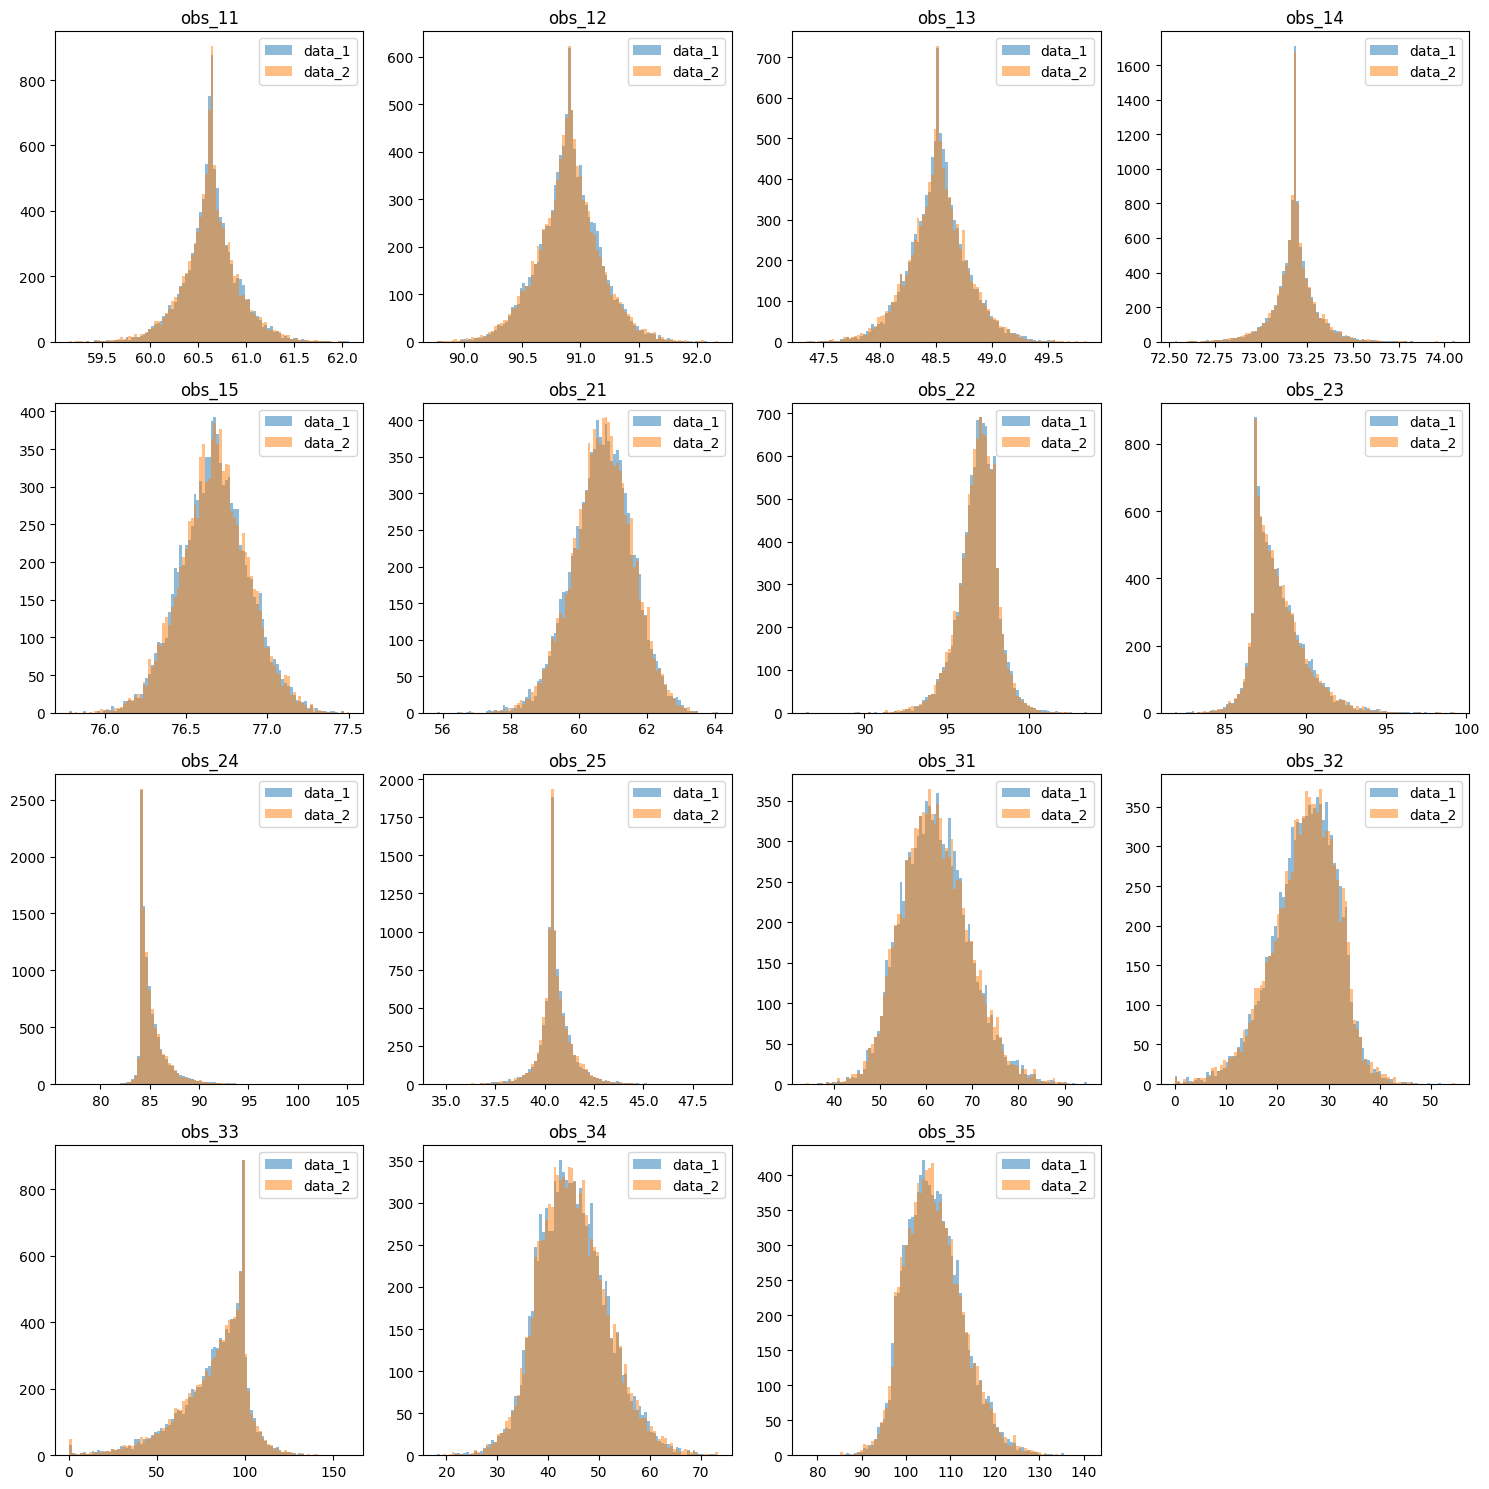

In [21]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=4, ncols=4)
for i, col in enumerate(df_1.columns[1:-2]):
    ax = axes[i//4, i%4]
    min_value = min(df_1[col].min(), df_2[col].min())
    max_value = max(df_1[col].max(), df_2[col].max())
    ax.hist(df_1[col], bins=np.linspace(min_value, max_value, 100), alpha=0.5, label="data_1")
    ax.hist(df_2[col], bins=np.linspace(min_value, max_value, 100), alpha=0.5, label="data_2")
    ax.set_title(col)
    ax.legend()
fig.delaxes(axes[-1, -1])
fig.tight_layout()
plt.show()

確認は省略しますが、同様の理由から、test.csvに含まれる値の分布も、上記と差異はありません。

また蛇足ですが、このように異なるデータのヒストグラムを重ねる場合、ビン数を指定するだけではビンの幅が異なる可能性があります。  
なぜなら、ビンの幅は、それぞれのデータの最小値、最大値をもとに決定されるからです。  
したがって、ここでは両方のデータの最小値、最大値を算出した上で、明示的にビン幅を指定しました。  
なお、データ数が異なる場合は、histメソッドの引数`density`に`True`を指定するとよいです。

---

## 2. 分析アプローチ

繰り返しになりますが、今回のタスクの目的は「spec値を100にするようなparameterの値を推測する」ことです。  
そして評価指標は、「**提出したparameterの値で実際に生産が行われた場合の、（100からの）平均絶対偏差**」です。  
（今回は人工データを生成しているため、このような評価がコンピュータ上で可能です。）

しかし、parameterを変えたときにspec値がどうなるかを、（ある程度推測することはできても）手元で完全に把握することは不可能です。  
つまり、今回の評価指標は原理上、手元でバリデーションを行うことができません。  
その点が、今回のタスクが一般的な機械学習コンペティション (MLコンペ) と決定的に異なる点です。  
（言葉による説明だけだとピンと来ないかもしれませんが、実際に取り組もうとしてみると、すぐにわかると思います。）

これを現実の問題として考えた場合、新しいparameterの決定アルゴリズムは、例えば少量の試験生産によって評価できるでしょう。  
MLコンペの文脈では、まさにPublic Scoreがその役割を果たします。  
（その意味もあり、今回はPublic Scoreの算出比率を10%と低めに設定しています。）  
過信は禁物ですが、今回は一般的なMLコンペよりも、Public Scoreを参考にする必要性があるでしょう。

さて、このタスクにどうアプローチしていくべきでしょうか？  
機械学習でやれそうなことはいくつか思い付つくでしょう。

例えば、「中間測定値およびparameterの値からspec値を予測するモデルを学習する」ことはできそうです。  
もし今回のタスクがspec値の予測精度を競う普通のMLコンペであればそれで終わりです。  
しかし、今回はそこから一歩進んで「spec値を100にするようなparameterの値を推測する」必要があるので、それだけでは解決できません。

あるいは、「今回はparameterが推測対象なのだから、parameterをターゲットに機械学習モデルを作ればいいのでは？」という考えが浮かぶかもしれません。  
しかし、「specの値を100にするような」という条件が厄介ですね。  
手元のデータが spec = 100 のデータばかりであれば話は早いですが、決してそういうわけではありません。

このように、今回のタスクは何かMLモデルを作って、予測して終わり、という単純な話ではないということです。

> **[補足]**  
> 今回のような問題は、機械学習において「**逆解析（逆問題解析）**」と呼ばれる問題です。  
> 紹介になりますが、[明治大学の金子研HPのブログ](https://datachemeng.com/blog/)には、逆解析を含む様々なMLトピックが掲載されていますので、興味のある方はご参照ください。

しかし、上記の考えを少し発展させれば、いくつかアプローチ案も浮かんでくるでしょう。  
例えば1つの案として、


1. **中間測定値およびparameterの値からspec値を予測するモデルを学習する**
2. **テストデータのparameterの値を様々に変えて学習済みモデルに入力し、それぞれにおけるspec値の予測値を算出する**
3. **spec値の予測値が最も100に近いparameterを最適値として採用する**

というアプローチが考えられます。  
以降では、このアプローチを例に、説明をしていきます。

## 3. 機械学習による入出力関係の学習

先ほど記載した手順に沿い、まずは、

1. **中間測定値およびparameterの値からspec値を予測するモデルを学習する**

を行いましょう。  
data_1.csvにはparamterが固定値しか入っていませんが、中間測定値とspec値の関係性を学習する上では、十分有用と考えられます。  
したがって、両者のデータを結合した上で、交差検証でモデルを学習・評価してみます。  
ここでは、テーブル形式のデータに対して経験上強力とされている勾配ブースティング木 (GBDT) のライブラリであるLightGBMを使ってモデリングを行います。

In [22]:
# データを結合
df = pd.concat([df_1, df_2], ignore_index=True)

In [23]:
X = df.drop(["id", "spec"], axis=1)
y = df["spec"]

# lightgbmの設定パラメータ
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1
}

# 学習済みモデルのリスト
models = []

# 予測値を格納する配列
preds_valid = np.zeros(len(df))

# 交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for i, (idx_train, idx_valid) in enumerate(kf.split(X)):
    print(f"fold:{i+1} train:{len(idx_train)} valid:{len(idx_valid)}")

    # 学習データ分割
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # lightgbm専用のデータ形式に変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)

    # モデル学習
    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=["train", "valid"],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    models.append(model)

    # バリデーションデータに対する予測値を格納
    preds_valid[idx_valid] = model.predict(X_valid)

r2 = r2_score(y, preds_valid)
print(f"決定係数: {r2:.5f}")

fold:1 train:16000 valid:4000
fold:2 train:16000 valid:4000
fold:3 train:16000 valid:4000
fold:4 train:16000 valid:4000
fold:5 train:16000 valid:4000
決定係数: 0.63018


バリデーションの結果、決定係数の値は約0.63となりました。  
決定係数は、ターゲットの分散の内、モデルで予測できている分散の割合であり、ターゲットの変動の6割以上をモデルで学習できていると解釈できます。  
入出力関係をそれなりにモデリングできていると言えそうです。

## 4. parameterに応じたspec値の予測値の算出

次に、交差検証で学習したモデルを使って、

2. **テストデータのparameterの値を様々に変えて学習済みモデルに入力し、それぞれにおけるspec値の予測値を算出する**

を行いましょう。  
parameterの設定可能範囲は-10～+10なので、その区間を0.5刻みで探索することにします。

In [24]:
df_test = pd.read_csv(INPUT_DIR + "test.csv")

In [25]:
search_space = np.linspace(-10, 10, 41)
search_space

array([-10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,  -6. ,
        -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,  -1.5,
        -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,
         3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,
         8. ,   8.5,   9. ,   9.5,  10. ])

まずはわかりやすさのために、テストデータの先頭1行のみに対して予測を出力し、結果を確認します。  
下記のコードでは、交差検証で学習した5つのモデルの平均値で、各paramterの値を入力したときのspecの予測値を出力しています。

In [26]:
x = df_test.drop("id", axis=1).iloc[[0]].copy()
list_pred = []
for parameter in search_space:
    # 入力するparameterの値を設定
    x["parameter"] = parameter

    # 5つのモデルの予測値の平均
    pred = 0
    for model in models:
        pred += model.predict(x)[0] / 5

    # 結果を出力
    print(f"parameter = {parameter:.1f}: {pred:.3f}")
    list_pred.append(pred)

parameter = -10.0: 94.783
parameter = -9.5: 94.783
parameter = -9.0: 94.783
parameter = -8.5: 94.783
parameter = -8.0: 94.783
parameter = -7.5: 94.783
parameter = -7.0: 94.783
parameter = -6.5: 94.783
parameter = -6.0: 94.783
parameter = -5.5: 94.783
parameter = -5.0: 94.783
parameter = -4.5: 94.783
parameter = -4.0: 94.803
parameter = -3.5: 94.857
parameter = -3.0: 95.016
parameter = -2.5: 95.311
parameter = -2.0: 95.486
parameter = -1.5: 95.826
parameter = -1.0: 95.975
parameter = -0.5: 96.158
parameter = 0.0: 96.278
parameter = 0.5: 97.883
parameter = 1.0: 98.074
parameter = 1.5: 98.342
parameter = 2.0: 98.573
parameter = 2.5: 98.664
parameter = 3.0: 98.764
parameter = 3.5: 98.924
parameter = 4.0: 99.205
parameter = 4.5: 99.000
parameter = 5.0: 99.000
parameter = 5.5: 99.000
parameter = 6.0: 99.000
parameter = 6.5: 99.000
parameter = 7.0: 99.000
parameter = 7.5: 99.000
parameter = 8.0: 99.000
parameter = 8.5: 99.000
parameter = 9.0: 99.000
parameter = 9.5: 99.000
parameter = 10.0: 9

テキスト出力だけでは傾向を掴みづらいので、上記の結果をグラフで可視化してみましょう。

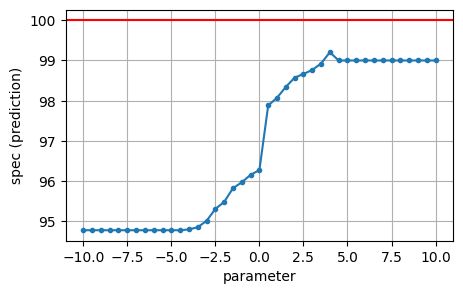

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(search_space, list_pred, marker=".")
plt.axhline(100, color="red")
plt.xlabel("parameter")
plt.ylabel("spec (prediction)")
plt.grid()
plt.show()

この図を見ると、

- parameterを大きくするほどspecの予測値も大きくなる傾向にある
- parameterをどれだけ大きくしても、specの予測値は目標の100に到達しない
- spec値の予測値が最も100に近いのは parameter=4.0 のときである
- parameter0近辺で予測値の急激な変化がある一方、-5以下および+5以上の区間では、予測値は変化していない

といったことがわかります。  
特に3点目のように、単調な傾向が崩れているのは、不自然な挙動に思えます。  
果たして、この結果を鵜呑みにしてよいのでしょうか？  
ここでもやはり注意が必要です。

まず、data_2.csvに含まれるデータにおいて、parameterの範囲は±5以内であったことを思い出しましょう。  
parameterに-10～+10の範囲を設定できるとは言え、過去の実績データには-5~+5より外のデータは存在していないのです。  
これは、機械学習モデルにとって、完全に「外挿」の問題になります。  
また、-5～+5の範囲内であっても、データ数が少ない領域では、外挿にかなり近い状態になると考えた方がよいです。  

外挿の結果がどのようになるかは、用いる機械学習モデルに大きく依存します。  
GBDTは決定木をベースとした手法であるため、入力にどれだけ大きい/小さい値が来たとしても、学習データにおける最大値/最小値と同じ扱いとなります。  
したがって、上で出力した図のように、学習データの入力範囲外では、予測値は変化しない結果になります。  

また、決定木は区分的に定数を割り当てるモデルのため、入力の変化に対する予測値の変化は、必然的に非連続的になります。  
（入力がある値をまたいだときに、予測値が非連続的に上がったり下がったりします。）  
その結果として、入力の変化に対する出力の応答が、直感に合わない傾向を示すことがあります。  
一方、仮に線形モデルを使えば、学習データ範囲の内外を問わず、予測値は直線的に変化します。

そもそも、機械学習で外挿に対処すること自体が難しいのですが、どうしてもそのような状況に対処する必要がある場合は、  
用いる手法のアルゴリズムと、データの背景に存在するドメイン知識から、その妥当性を考えなければいけません。  

ここでは一旦、探索する範囲だけを-3～+3に変更して、全テストデータに対する予測値を得ることにしましょう。

In [28]:
search_space = np.linspace(-3, 3, 13)
search_space

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ])

In [29]:
X_test = df_test.drop("id", axis=1).copy()

# 予測値を格納する配列
preds_test = np.zeros((len(df_test), len(search_space)))

for i, parameter in enumerate(search_space):
    # 入力するparameterの値を設定
    X_test["parameter"] = parameter

    # 5つのモデルの予測値の平均
    for model in models:
        preds_test[:, i] += model.predict(X_test) / 5

In [30]:
preds_test

array([[ 95.01587282,  95.31135377,  95.48645616, ...,  98.57293126,
         98.66435948,  98.76447013],
       [ 97.63655352,  97.95965226,  98.28740027, ..., 101.22229861,
        101.37840813, 101.54921254],
       [ 97.38161852,  97.82934267,  98.00177405, ..., 100.27955568,
        100.27765421, 100.36911031],
       ...,
       [ 96.61290325,  97.06658062,  97.32757967, ..., 100.02519619,
        100.01074598,  99.98385844],
       [100.4520509 , 100.3852135 , 100.4812794 , ..., 103.22004955,
        103.37136319, 103.59723702],
       [ 99.02950848,  99.2580379 ,  99.49513307, ..., 101.299093  ,
        101.47043764, 101.63346508]])

In [31]:
preds_test.shape

(10000, 13)

10,000行のテストデータに対し、parameterの値に応じた13パターンの予測値が各列に格納されています。

## 5. parameterの最適値の探索

最後に、

3. **spec値の予測値が最も100に近いparameterを最適値として採用する**

を行いましょう。  
各行に対して予測値が100に最も近いケースを知るには、例えばnumpyのargmin関数を用いればよいです。  
（最小となるケースが複数ある場合、argmin関数は最初のindexを返します。）

In [32]:
idx_min = np.argmin(np.abs(preds_test - 100), axis=1)
idx_min

array([12,  7,  9, ..., 11,  1,  4])

各行に対して、何番目の列の値が最も100に近いかが計算されています。  
これを用いれば、各行に対して最適なparamterを以下のように抽出できます。

In [33]:
opt_params = search_space[idx_min]
opt_params

array([ 3. ,  0.5,  1.5, ...,  2.5, -2.5, -1. ])

In [34]:
df_sub = df_test[["id"]].copy()
df_sub["parameter"] = opt_params
df_sub.to_csv(OUTPUT_DIR + "tutorial.csv", index=False)
df_sub

,id,parameter
0,20000,3.0
1,20001,0.5
2,20002,1.5
3,20003,-1.5
4,20004,-2.0
...,...,...
9995,29995,2.5
9996,29996,2.5
9997,29997,2.5
9998,29998,-2.5


この結果を提出すると **Public Score = 1.081** という結果を得ます。  
（ライブラリのバージョン等によって、異なるスコアが出る可能性があります。）  
Puclic Score上では、現行モデルよりもいい設定ができているように見えますが、まだまだ改善の余地はあるでしょう。

今回のコンペティションのデータは人工データであり、データの各列に特に物理的な意味付けがあるわけではありません。    
したがって、特徴量エンジニアリングによるモデル精度改善の余地は、ほとんど無いと考えてください。  
今回は、逆解析という少し特殊なテーマにおいて、機械学習をどのように応用するか、そこに焦点を当てていただければ幸いです。

チュートリアルは以上です。  
本noteboookも参考にしていただきながら、ぜひトライしてみてください。